Читаем библиотеки

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [2]:
from tensorflow.keras.callbacks import EarlyStopping

Разбор текста - Токенизация

In [3]:
# Создаем объект для токенизапции
tokenizer = Tokenizer( num_words=10000)
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()
#Читаем текст
corpus = data.lower().split("\n")

--2021-06-01 15:44:06--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-06-01 15:44:06 (131 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [4]:
corpus[:10]

['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou, contracted to thine own bright eyes,',
 "feed'st thy light'st flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thyself thy foe, to thy sweet self too cruel.',
 "thou that art now the world's fresh ornament",
 'and only herald to the gaudy spring,']

Исполним токенизацию и кодирование

In [5]:
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [6]:
token_list

[]

In [7]:
tokenizer.index_word[10]

'thou'

In [8]:
tokenizer.word_index['love']

14

In [9]:
input_sequences[11:15,:]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,   0,   0,   0,  16,  22,   2, 879,  61]],
      dtype=int32)

In [10]:
label.shape

(15462, 3211)

Создаем сеть

In [11]:
callback = EarlyStopping(monitor='val_loss', patience=5) # создаем обратный вызов - calback - тут "Ранний останов"

In [12]:
model = Sequential()
model.add(Embedding(total_words, 10, input_length=max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 10) координат - он плотный
#model.add(Bidirectional(LSTM(50, return_sequences = True)))

model.add(LSTM(10))
model.add(Dropout( 0.2))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 10)            32110     
_________________________________________________________________
lstm (LSTM)                  (None, 10)                840       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1605)              17655     
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 5,207,471
Trainable params: 5,207,471
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
 history = model.fit(predictors, label, epochs=100, validation_split=0.2, callbacks=[callback],verbose=1)

Epoch 1/100
387/387 [==============================] - 11s 8ms/step - loss: 6.9710 - accuracy: 0.0214 - val_loss: 6.8806 - val_accuracy: 0.0165
Epoch 2/100
387/387 [==============================] - 3s 7ms/step - loss: 6.5531 - accuracy: 0.0251 - val_loss: 6.9739 - val_accuracy: 0.0165
Epoch 3/100
387/387 [==============================] - 3s 7ms/step - loss: 6.4826 - accuracy: 0.0233 - val_loss: 7.0172 - val_accuracy: 0.0178
Epoch 4/100
387/387 [==============================] - 3s 7ms/step - loss: 6.4299 - accuracy: 0.0226 - val_loss: 7.1005 - val_accuracy: 0.0158
Epoch 5/100
387/387 [==============================] - 3s 7ms/step - loss: 6.3886 - accuracy: 0.0242 - val_loss: 7.1556 - val_accuracy: 0.0178
Epoch 6/100
387/387 [==============================] - 3s 7ms/step - loss: 6.3489 - accuracy: 0.0278 - val_loss: 7.2349 - val_accuracy: 0.0197


Тест


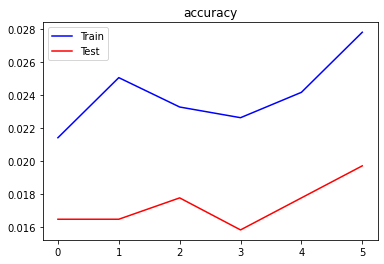

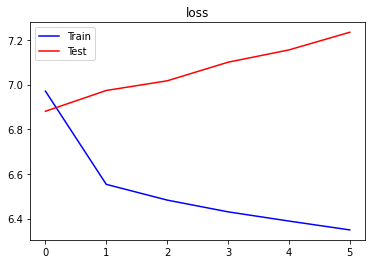

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.legend()

plt.show()

Строим тест генератора

In [15]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
#seed_text = "She is my girl, I see in my hend"
next_words = 10
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	print(token_list)
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
  #y_p=model.predict(token_list)
	output_word = ""
	y_p=model.predict(token_list)
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

[591, 18, 5, 352, 393]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[591, 18, 5, 352, 393, 2]
[591, 18, 5, 352, 393, 2, 14]
[591, 18, 5, 352, 393, 2, 14, 2]
[591, 18, 5, 352, 393, 2, 14, 2, 14]
[591, 18, 5, 352, 393, 2, 14, 2, 14, 2]
[591, 18, 5, 352, 393, 2, 14, 2, 14, 2, 14]
[591, 18, 5, 352, 393, 2, 14, 2, 14, 2, 14, 2]
[591, 18, 5, 352, 393, 2, 14, 2, 14, 2, 14, 2, 14]
[591, 18, 5, 352, 393, 2, 14, 2, 14, 2, 14, 2, 14, 2]
Help me Obi Wan Kenobi, you're my only hope the love the love the love the love the love


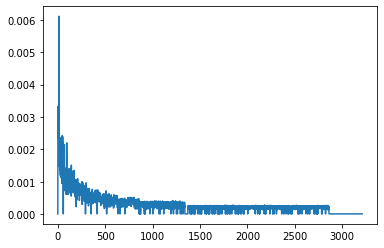

In [16]:
plt.plot(y_p[0,:])

In [19]:
ind_prob=np.where(y_p[0,:]>0.002500)[0]
ind_prob

array([ 2,  4,  5,  6,  7,  8,  9, 14])

In [23]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer.index_word[ind], ' : ', y_p[0,i])

the  :  8.244135e-06
of  :  0.002261047
my  :  0.003327034
i  :  0.0023361053
in  :  0.0025306498
that  :  0.0031354027
thy  :  0.0027497131
love  :  0.0029313304
